## Set up Environment

In [1]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

env = gym.make('Blackjack-v1')

## Define the Deep Q-Network (DQN)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(3, 128)  # 3 inputs: player score, dealer card, usable ace
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 2)  # 2 outputs: stick or hit

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

## Training the Network

In [4]:
def train_dqn(episodes):
    policy_net = DQN()
    optimizer = optim.Adam(policy_net.parameters(), lr=0.0001)
    memory = []  # Experience replay memory
    batch_size = 32
    gamma = 0.99  # Discount factor
    losses = []  # List to store loss values for plotting
    interval_losses = []  # List to store average losses per interval

    for episode in range(episodes):
        state, _ = env.reset()
        total_loss = 0
        steps = 0

        while True:
            state_tensor = torch.tensor(state).float().unsqueeze(0)
            with torch.no_grad():
                action = policy_net(state_tensor).max(1)[1].item()
            next_state, reward, done, _, _ = env.step(action)
            
            memory.append((state, action, next_state, reward, done))
            state = next_state

            if len(memory) > batch_size:
                transitions = random.sample(memory, batch_size)
                batch_state, batch_action, batch_next_state, batch_reward, batch_done = zip(*transitions)

                batch_state = torch.tensor(batch_state).float()
                batch_action = torch.tensor(batch_action).long()
                batch_reward = torch.tensor(batch_reward).float()
                batch_next_state = torch.tensor(batch_next_state).float()
                batch_done = torch.tensor(batch_done).int()

                current_q = policy_net(batch_state).gather(1, batch_action.unsqueeze(1)).squeeze(1)
                next_q = policy_net(batch_next_state).max(1)[0]
                expected_q = batch_reward + gamma * next_q * (1 - batch_done)

                loss = nn.MSELoss()(current_q, expected_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                steps += 1

            if done:
                break
        
        # Record the average loss for this episode
        average_loss = total_loss / steps if steps > 0 else 0
        losses.append(average_loss)

        if (episode + 1) % 10000 == 0:
            interval_average_loss = sum(losses[-10000:]) / 10000
            interval_losses.append(interval_average_loss)
            print(f"Episode {episode+1}: Interval Average Loss: {interval_average_loss}")

    return policy_net, losses


/Users/ivan/anaconda3/envs/dsan6600/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 10000: Interval Average Loss: 0.6083703638965888
Episode 20000: Interval Average Loss: 0.5123221006721759
Episode 30000: Interval Average Loss: 0.4929172643123061
Episode 40000: Interval Average Loss: 0.4847275008159135
Episode 50000: Interval Average Loss: 0.4839233589976028
Episode 60000: Interval Average Loss: 0.48066964068894585
Episode 70000: Interval Average Loss: 0.48085020588643884
Episode 80000: Interval Average Loss: 0.4807758559698852
Episode 90000: Interval Average Loss: 0.4801897410771746
Episode 100000: Interval Average Loss: 0.4813017365284759
Episode 110000: Interval Average Loss: 0.4825458086232342
Episode 120000: Interval Average Loss: 0.48331012103177584
Episode 130000: Interval Average Loss: 0.48240388060477923
Episode 140000: Interval Average Loss: 0.48156517604783206
Episode 150000: Interval Average Loss: 0.4823526427985731
Episode 160000: Interval Average Loss: 0.48157378310705223
Episode 170000: Interval Average Loss: 0.4806239235608284
Episode 180000: I

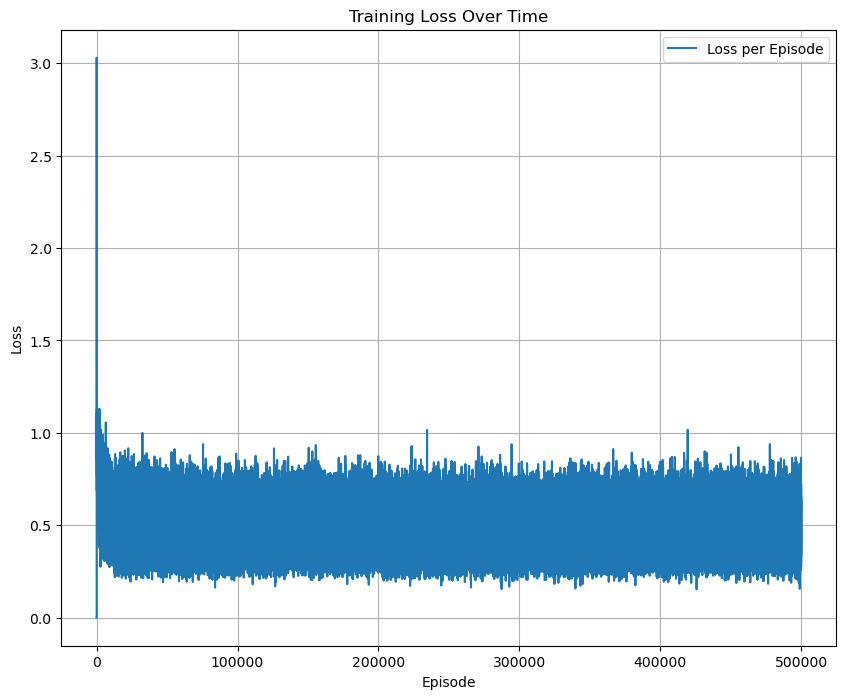

In [5]:
policy_net, losses = train_dqn(500000)  # Train for 500000 episodes

# Plotting the loss over episodes
plt.figure(figsize=(10, 8))
plt.plot(losses, label='Loss per Episode')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

## Optimal Policy

In [6]:
def plot_policy(policy):

    def get_Z(player_hand, dealer_showing, usable_ace):
        if (player_hand, dealer_showing, usable_ace) in policy:
            return policy[player_hand, dealer_showing, usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(1, 11)
        y_range = np.arange(11, 22)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(player_hand, dealer_showing, usable_ace) for dealer_showing in x_range] for player_hand in range(21, 10, -1)])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 2), vmin=0, vmax=1, extent=[0.5, 10.5, 10.5, 21.5])
        plt.xticks(x_range, ('A', '2', '3', '4', '5', '6', '7', '8', '9', '10'))
        plt.yticks(y_range)
        ax.set_xlabel('Dealer Showing')
        ax.set_ylabel('Player Hand')
        ax.grid(color='black', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0, 1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
        cbar.ax.invert_yaxis() 
            
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace', fontsize=16)
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace', fontsize=16)
    get_figure(False, ax)
    plt.show()

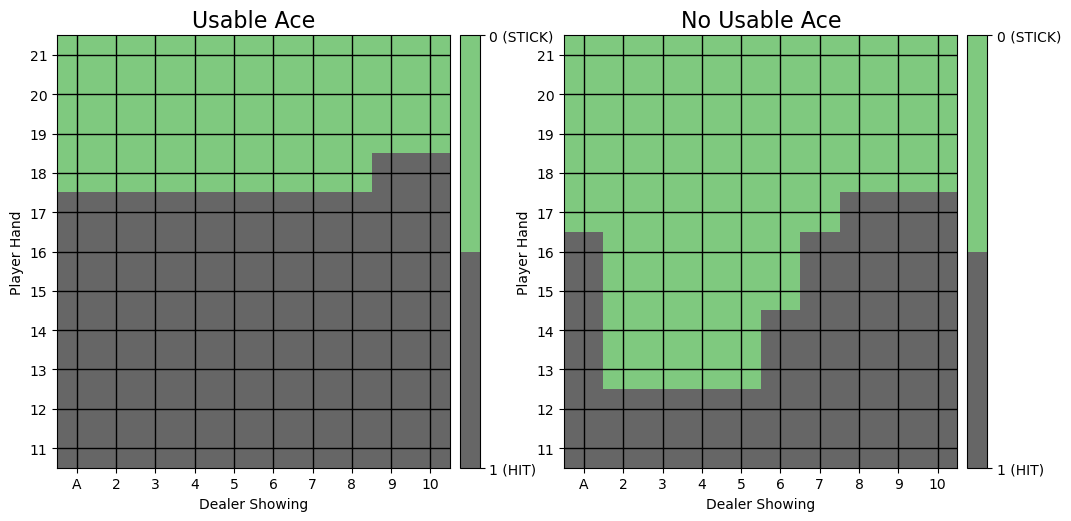

In [7]:
def extract_policy(policy_net):
    policy = {}
    for player_hand in range(12, 22):
        for dealer_showing in range(1, 11):
            for usable_ace in [0, 1]:
                state = (player_hand, dealer_showing, usable_ace)
                state_tensor = torch.tensor(state).float().unsqueeze(0)
                action = policy_net(state_tensor).max(1)[1].item()
                policy[state] = action
    return policy

policy = extract_policy(policy_net)
plot_policy(policy)

## Average Payoff

In [12]:
def calc_payoffs(env, rounds, players, policy):
    """
    Calculate and plot the average payoff.
    """
    average_payouts = []
    for player in range(players):
        total_payout = 0  # Store total payout over 'rounds'

        for _ in range(rounds):
            state, _ = env.reset()  # Reset for a new round/game
            done = False
            while not done:
                player_hand, dealer_card, usable_ace = state
                action = policy.get((player_hand, dealer_card, usable_ace), 1)  # Default to action 'hit' if uncertain
                state, payout, done, info, _ = env.step(action)
                if done:
                    total_payout += payout  # Add payout from this round

        average_payouts.append(total_payout / rounds)  # Average payout for current player

    plt.plot(range(players), average_payouts)
    plt.xlabel('Player Number')
    plt.ylabel(f'Average payoff after {rounds} Rounds')
    plt.show()
    
    print(f"Average payoff of a player after {rounds} rounds is {np.mean(average_payouts)}")

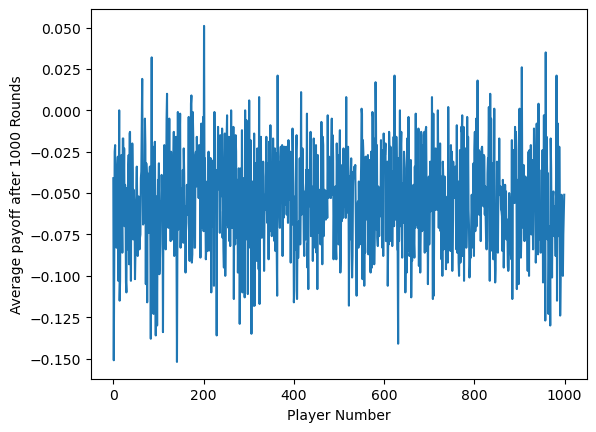

Average payoff of a player after 1000 rounds is -0.05446600000000001


In [13]:
env.reset()
calc_payoffs(env,1000,1000,policy)